# 03 - Train and Deploy

In [2]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]

prefix = 'sagemaker-intel-dvc'

print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 523843493491
bucket: sagemaker-us-west-2-523843493491
region: us-west-2
role: arn:aws:iam::523843493491:role/service-role/AmazonSageMaker-ExecutionRole-20220211T001925


In [3]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import TensorBoardOutputConfig

Commit Hash: `9915322bdef503068b5ef332506cf34cb32901f7`

In [4]:
dvc_repo_url = "codecommit::us-west-2://sagemaker-intel"
dvc_branch = "processed-dataset"

In [5]:
tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path=f's3://{bucket}/sagemaker-intel-logs',
    container_local_output_path='/opt/ml/output/tensorboard'
)

In [6]:
pt_estimator = PyTorch(
    base_job_name="training-intel-dataset",
    source_dir="utils",
    entry_point="train.py",
    role=get_execution_role(),
    py_version="py38",
    framework_version="1.12",
    image_uri='523843493491.dkr.ecr.us-west-2.amazonaws.com/emlov2-private-repo-yaseen:latest',
    instance_count=1,
    # instance_type="ml.m5.large",
    instance_type="ml.g4dn.xlarge",
    tensorboard_output_config=tensorboard_output_config,
    use_spot_instances=True,
    max_wait=1800,
    max_run=1500,
    environment={
        "DVC_REPO_URL": dvc_repo_url,
        "DVC_BRANCH": dvc_branch,
        "GIT_USER": "Mohammed Yaseen",
        "GIT_EMAIL": "47.yaseen@gmail.com"
    }
)

In [9]:
pt_estimator.fit()

INFO:sagemaker:Creating training-job with name: training-intel-dataset-2023-02-12-15-27-11-011


2023-02-12 15:27:11 Starting - Starting the training job...
2023-02-12 15:27:28 Starting - Preparing the instances for training.........
2023-02-12 15:29:00 Downloading - Downloading input data...
2023-02-12 15:29:21 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-12 15:32:53,829 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-12 15:32:53,850 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-02-12 15:32:53,861 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-12 15:32:53,865 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-12 15:32:54,039 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-02-12 15:32:54,074 sagemaker-training-toolkit INFO

## Deploy to Endpoint

In [7]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

Get the `model_data` from the models uploaded to S3 of the aboved training

Once your debugging is done, it's better to simply call `pt_estimator.deploy`

In [8]:
model = PyTorchModel(
    entry_point="infer.py",
    source_dir="utils",
    role=get_execution_role(),
    model_data="s3://sagemaker-us-west-2-523843493491/training-intel-dataset-2023-02-12-15-27-11-011/output/model.tar.gz",
    framework_version="1.12.0",
    py_version="py38",
    # image_uri='523843493491.dkr.ecr.us-west-2.amazonaws.com/emlov2-private-repo-yaseen:latest'
)

In [41]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-12-20-51-48-610
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-02-12-20-51-49-209
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-02-12-20-51-49-209


--------!

## Predictor

In [9]:
from sagemaker.pytorch import PyTorchPredictor

Predictor is also not needed to be created again, but today we want to be verbose

In [10]:
predictor_new = PyTorchPredictor(
    endpoint_name="pytorch-inference-2023-02-12-20-51-49-209",
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

In [11]:
import numpy as np

In [12]:
dummy_data = {"inputs": np.random.randn(1, 3, 224, 224)}

In [13]:
out = predictor_new.predict(dummy_data)

In [14]:
out

[{'forest': 0.6315997242927551,
  'buildings': 0.20310011506080627,
  'street': 0.1272009015083313,
  'glacier': 0.019703254103660583,
  'sea': 0.012445828877389431}]

In [15]:
out = np.array(out)

In [16]:
out.shape

(1,)

In [32]:
classnames = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [19]:
from pathlib import Path

In [30]:
# ! wget -O daisy.jpg "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/marguerite-daisy-types-1586981163.jpg"
images = ['10004.jpg', '10048.jpg', '10021.jpg', '10059.jpg', '10034.jpg', '10054.jpg', '10005.jpg', '10013.jpg', '1003.jpg', '10038.jpg', '10012.jpg', '10045.jpg']
dataset_extracted = Path("/root/emlov2-session-12/")

dataset_pred = [(dataset_extracted / "seg_pred" / "seg_pred" / img_pth) for img_pth in images]
# labels_train = [x.parent.stem for x in dataset_train]

In [26]:
import torch

import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image

We could have done all this in infer.py as well, but today we are being verbose :p

In [ ]:
# daisy_im.resize((224, 224))

In [ ]:
# transforms = T.Compose([
#     T.ToTensor(),
#     T.Resize((224, 224)),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [ ]:
# daisy_img_t = transforms(daisy_im)

In [48]:
# all_images = [Image.open(img)[...].numpy().tolist() for img in dataset_pred]
all_images = np.array([np.array(Image.open(fname)).transpose(2, 0, 1) for fname in dataset_pred]) # transpose to bring channels first

In [49]:
all_images.shape

(12, 3, 150, 150)

In [50]:
# daisy_input = {"inputs": daisy_img_t[None, ...].numpy().tolist()}
img_input = {"inputs": all_images.tolist()}

In [51]:
out = predictor_new.predict(img_input)

In [52]:
out

[{'buildings': 1.0,
  'sea': 1.6794168279624588e-25,
  'street': 6.694399890927259e-31,
  'mountain': 0.0,
  'glacier': 0.0},
 {'buildings': 1.0,
  'street': 1.6176176038025084e-20,
  'sea': 2.3703494896431953e-37,
  'mountain': 0.0,
  'glacier': 0.0},
 {'buildings': 1.0,
  'street': 4.796061254807181e-37,
  'mountain': 0.0,
  'sea': 0.0,
  'glacier': 0.0},
 {'buildings': 1.0,
  'street': 3.645508955833719e-21,
  'sea': 1.2924198258613468e-21,
  'mountain': 0.0,
  'glacier': 0.0},
 {'buildings': 1.0,
  'street': 9.09453650638777e-19,
  'sea': 2.677486051273844e-23,
  'glacier': 3.8229318544214983e-32,
  'mountain': 0.0},
 {'buildings': 1.0,
  'street': 4.7318232823145895e-21,
  'sea': 1.8406005563204252e-23,
  'mountain': 0.0,
  'glacier': 0.0},
 {'buildings': 0.9999794960021973,
  'street': 2.0502155166468583e-05,
  'mountain': 0.0,
  'sea': 0.0,
  'glacier': 0.0},
 {'buildings': 1.0,
  'street': 8.245597094003188e-09,
  'sea': 5.605193857299268e-45,
  'mountain': 0.0,
  'glacier': 0.

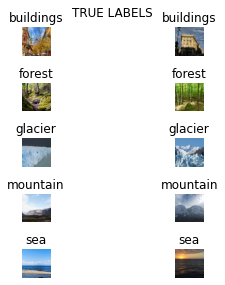

In [59]:
# fig,ax = plt.subplots(5,2)

for i in range(10):
    with open(dataset_pred[i],'rb') as f:
        image=Image.open(f)
        # Adds a subplot at the 1st position
        plt.subplot(5, 2, i+1)
  
        # showing image
        plt.imshow(image)
        plt.axis('off')
        plt.title(classnames[i//2])

plt.tight_layout()
plt.suptitle("TRUE LABELS")
plt.show()

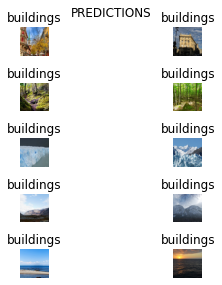

In [60]:
for i in range(10):
    with open(dataset_pred[i],'rb') as f:
        image=Image.open(f)
        # Adds a subplot at the 1st position
        plt.subplot(5, 2, i+1)
  
        # showing image
        plt.imshow(image)
        plt.axis('off')
        plt.title(max(out[i], key=out[i].get))

plt.tight_layout()
plt.suptitle("PREDICTIONS")
plt.show()

In [54]:
# out_t = torch.tensor(out)

In [ ]:
# out_t.shape

In [ ]:
# F.softmax(out_t, dim=-1)

In [ ]:
# f"Prediction: {classnames[torch.argmax(out_t, dim=-1)[0]]}"

### Testing

In [ ]:
! pip install --quiet timm pytorch-lightning

In [ ]:
from typing import Any, Dict, Optional, Tuple

import os
import subprocess
import torch
import timm

import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F

from pathlib import Path
from torchvision.datasets import ImageFolder
from pytorch_lightning.plugins.environments import LightningEnvironment
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy

In [ ]:
class LitResnet(pl.LightningModule):
    def __init__(self, num_classes=10, lr=0.05):
        super().__init__()

        self.num_classes = num_classes
        self.save_hyperparameters()
        self.model = timm.create_model('resnet18', pretrained=True)

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_classes)

        if stage:
            self.log(f"{stage}/loss", loss, prog_bar=True)
            self.log(f"{stage}/acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        return {"optimizer": optimizer}


In [ ]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data/",
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        
        self.data_dir = Path(data_dir)

        # data transformations
        self.transforms = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.data_train: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    @property
    def num_classes(self):
        return len(self.data_train.classes)
    
    @property
    def classes(self):
        return self.data_train.classes

    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.
        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_test:
            trainset = ImageFolder(self.data_dir / "train", transform=self.transforms)
            testset = ImageFolder(self.data_dir / "test", transform=self.transforms)
            
            self.data_train, self.data_test = trainset, testset

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass



In [ ]:
datamodule = FlowerDataModule(data_dir=(Path("/root/flower-project/example-git/") / "dataset").absolute())
datamodule.setup()

In [ ]:
datamodule.num_classes

In [ ]:
model = LitResnet(num_classes=datamodule.num_classes)

In [ ]:
trainer = pl.Trainer(
    max_epochs=2,
    accelerator="auto",
)

In [ ]:
trainer.fit(model, datamodule)